1.2 CoefficientFunctions
====

In NGSolve, `CoefficientFunction`s are representations of functions defined on the computational domain. Examples are expressions of coordinate variables $x, y, z$ and functions that are  constant on subdomains. Much of the magic behind the seamless integration of NGSolve with python lies in `CoefficientFunction`s. This tutorial introduces you to them.

After this tutorial you will know how to 

- **define** a `CoefficientFunction`,
- **visualize**  a `CoefficientFunction`,
- **evaluate** `CoefficientFunction`s at points,
- print the **expression tree** of `CoefficientFunction`,
- **integrate** a `CoefficientFunction`, 
- **differentiate** a `CoefficientFunction`, 
- include **parameter** in `CoefficientFunction`s,
- **interpolate** a `CoefficientFunction` into a finite element space, 
- define **vector-valued** `CoefficientFunction`s, and 
- **compile** `CoefficientFunction`s.

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
mesh = Mesh (unit_square.GenerateMesh(maxh=0.2))

### Define a function

In [2]:
myfunc = x*(1-x)
myfunc   # You have just created a CoefficientFunction

In [3]:
x        # This is a built-in CoefficientFunction

### Visualize the function

Use the `mesh` to visualize the function.

In [4]:
Draw(myfunc, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

### Evaluate the function

In [5]:
mip = mesh(0.2, 0.2)
myfunc(mip)

0.16000000000000003

Note that `myfunc(0.2,0.3)` will not evaluate the function: one must give points in the form of `MappedIntegrationPoint`s like `mip` above. The `mesh` knows how to produce them.

### Examining functions on sets of points

In [6]:
pts = [(0.1*i, 0.2) for i in range(11)]
vals = [myfunc(mesh(*p)) for p in pts] 
for p,v in zip(pts, vals):
    print("point=(%3.2f,%3.2f), value=%6.5f"
         %(p[0], p[1], v))

point=(0.00,0.20), value=0.00000
point=(0.10,0.20), value=0.09000
point=(0.20,0.20), value=0.16000
point=(0.30,0.20), value=0.21000
point=(0.40,0.20), value=0.24000
point=(0.50,0.20), value=0.25000
point=(0.60,0.20), value=0.24000
point=(0.70,0.20), value=0.21000
point=(0.80,0.20), value=0.16000
point=(0.90,0.20), value=0.09000
point=(1.00,0.20), value=0.00000


Here is the vectorized version of the same code using `numpy`.

In [7]:
import numpy as np
X = np.linspace(0, 1, num=11)
Y = np.ones_like(X) * 0.2
myfunc(mesh(X, Y))

array([[0.  ],
       [0.09],
       [0.16],
       [0.21],
       [0.24],
       [0.25],
       [0.24],
       [0.21],
       [0.16],
       [0.09],
       [0.  ]])

We may plot the restriction of the `CoefficientFunction` on a line using matplotlib. 

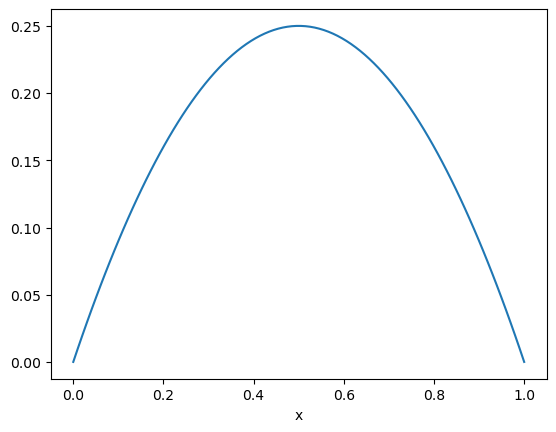

In [8]:
X = np.linspace(0, 1, num=100)
Y = np.ones_like(X) * 0.2
plt.plot(X, myfunc(mesh(X, Y)))
plt.xlabel('x')
plt.show()

### Expression tree of a function

Internally, coefficient functions are implemented as an expression tree made from building blocks like `x`, `y`, `sin`, etc., and arithmetic operations. (Knowing this will provide context for the later discussion of speeding up their evaluations.) For example, the expression tree for `myfunc = x*(1-x)` looks like this:

In [9]:
print(myfunc) 

coef binary operation '*', real
  coef coordinate x, real
  coef binary operation '-', real
    coef 1, real
    coef coordinate x, real



### Integrate a function

We can numerically integrate the function using the mesh:

In [10]:
Integrate(myfunc, mesh, order=5)

0.166666666666666

You can change the precision of the quadrature rule used for the integration using the key word argument `order`. 

### Differentiate a function

Automatic differentiation of a `CoefficientFunction` is possible through the `Diff` method. Here is how you get $\partial / \partial x$ of `myfunc`:

In [11]:
diff_myfunc = myfunc.Diff(x)
Draw(diff_myfunc, mesh, "derivative");

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

See if you can recognize an implementation of the product rule 

$$
\frac{\partial}{\partial x} x (1-x)
= 
\frac{\partial x}{\partial x} 
(1-x) + 
x\frac{\partial (1-x)}{\partial x} 
$$

in the tree-representation of the differentiated coefficient function, printed below.

In [12]:
print(diff_myfunc)

coef binary operation '+', real
  coef binary operation '*', real
    coef coordinate x, real
    coef scale -1, real
      coef 1, real
  coef binary operation '*', real
    coef binary operation '-', real
      coef 1, real
      coef coordinate x, real
    coef 1, real



### Parameters in functions

When building complex coefficient functions from simple ones like `x` and `y`, you may often want to introduce `Parameter`s, which are constants whose value may be changed later.

In [13]:
k = Parameter(1.0)
f = sin(k*y)
Draw(f, mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

The same `f` may be given a different value of `k` later:

In [14]:
k.Set(10)
Draw(f, mesh, order=3);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Look at the expression tree of `f`:

In [15]:
print(f)

coef unary operation 'sin', real
  coef binary operation '*', real
    coef class ngfem::ParameterCoefficientFunction<double>, real
    coef coordinate y, real



Note how the parameter
is now a **node** in the expression tree.  You can differentiate a coefficient function with respect to such quantities by passing it as argument to `Diff`:

In [16]:
print (f.Diff(k))

coef binary operation '*', real
  coef unary operation 'cos', real
    coef binary operation '*', real
      coef class ngfem::ParameterCoefficientFunction<double>, real
      coef coordinate y, real
  coef binary operation '*', real
    coef coordinate y, real
    coef 1, real



In [17]:
Integrate((f.Diff(k) - y*cos(k*y))**2, mesh)

0.0

### Interpolate a function

We may `Set` a `GridFunction` using a `CoefficientFunction`:

In [18]:
fes = H1(mesh, order=1)
u = GridFunction(fes)
u.Set(myfunc)
Draw(u); 

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

* The `Set` method interpolates `myfunc` to an element `u` in the finite element space.

* `Set` does an *Oswald-type interpolation* as follows:
    - It first zeros the grid function;
    - It then projects `myfunc` in $L^2$ on each mesh element;
    - It then averages dofs on element interfaces for conformity.
    
* We will see other ways to interpolate in [Unit 2.10](../unit-2.10-dualbasis/dualbasis.ipynb).

### Vector-valued `CoefficientFunction`

Here is an example of a vector-valued coefficient function.

In [19]:
vecfun = CoefficientFunction((-y, sin(x)))

Instead of writing the long name, you can abbreviate:

In [20]:
vecfun = CF((-y, sin(x)))   # CF = CoefficientFunction

To draw the vector field in the `webgui` using arrows, use the `vectors` keyword argument.

In [21]:
Draw(vecfun, mesh, vectors=True);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Another example of a vector-valued coefficient function is the gradient of a scalar `GridFunction`. Here is an example using the above-set `GridFunction` called `u`. The colors represent the magnitude of the vector field and the arrows give the direction. 

In [22]:
u.Set(myfunc)
gradu = grad(u)
Draw(gradu, mesh, vectors={"grid_size":30});

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

### Compiled `CoefficientFunction`

Evaluation of a `CoefficientFunction` at a point is usually done 
by traversing its expression tree and evaluating each node of the tree. When the tree has repeated nodes, this is likely wasteful. NGSolve allows you to **"compile"** a `CoefficientFunction` to increase the efficiency of its evaluation. The compilation translates the expression tree into a sequence of linear steps. 

Continuing with our simple `myfunc` example, here is how to use the `Compile` method:

In [23]:
myfunc_compiled = myfunc.Compile()

Now look at the differences between the compiled and non-compiled `CoefficientFunction`:

In [24]:
print(myfunc)

coef binary operation '*', real
  coef coordinate x, real
  coef binary operation '-', real
    coef 1, real
    coef coordinate x, real



In [25]:
print(myfunc_compiled)

Compiled CF:
Step 0: coordinate x
Step 1: 1
Step 2: binary operation '-'
     input: 1 0 
Step 3: binary operation '*'
     input: 0 2 



Evaluation of the compiled function is now a linear sequence of Steps 0, 1, 2, and 3 above. The output description of Steps 2 and 3 above means the following:

*  Step 2: (Output of Step 1) - (Output of Step 0) 
*  Step 3: (Output of Step 0) * (Output of Step 2) 

Here is another example, along with differences in timings for integrating the same coefficient function, in three different forms, on the same mesh. 

In [26]:
f0 = myfunc
f1 = f0*y 
f2 = f1*f1 + f1*f0 + f0*f0 
f3 = f2*f2*f2*f0**2 + f0*f2**2 + f0**2 + f1**2 + f2**2
final = f3 + f3 + f3 
finalc = final.Compile()

In [27]:
%timeit Integrate(final, mesh, order=10)

939 µs ± 35 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%timeit Integrate(finalc, mesh, order=10)

106 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


If your NGSolve installation has a compiler script (you likely do if you built NGSolve from source using a compiler/toolchain), then you additionally have the option of letting that script optimize your coefficient function further. Here is an example:

In [31]:
finalcc = final.Compile(realcompile=True, wait=True)

NgException: problem calling compiler

In [30]:
%timeit Integrate(finalcc, mesh, order=10)

NameError: name 'finalcc' is not defined

Clearly these experiments show that the evaluation of an expression tree can be made faster by compiling the tree into a set of linear instructions. This conclusion is also supported by looking at the long outputs of the expression tree with and without the compile option.

In [32]:
print(finalc)

Compiled CF:
Step 0: coordinate x
Step 1: 1
Step 2: binary operation '-'
     input: 1 0 
Step 3: binary operation '*'
     input: 0 2 
Step 4: coordinate y
Step 5: binary operation '*'
     input: 3 4 
Step 6: binary operation '*'
     input: 5 5 
Step 7: binary operation '*'
     input: 5 3 
Step 8: binary operation '+'
     input: 6 7 
Step 9: binary operation '*'
     input: 3 3 
Step 10: binary operation '+'
     input: 8 9 
Step 11: binary operation '*'
     input: 10 10 
Step 12: binary operation '*'
     input: 11 10 
Step 13: binary operation '*'
     input: 3 3 
Step 14: binary operation '*'
     input: 12 13 
Step 15: binary operation '*'
     input: 10 10 
Step 16: binary operation '*'
     input: 3 15 
Step 17: binary operation '+'
     input: 14 16 
Step 18: binary operation '*'
     input: 3 3 
Step 19: binary operation '+'
     input: 17 18 
Step 20: binary operation '*'
     input: 5 5 
Step 21: binary operation '+'
     input: 19 20 
Step 22: binary operation '*'
    

In [33]:
print(final)

coef binary operation '+', real
  coef binary operation '+', real
    coef binary operation '+', real
      coef binary operation '+', real
        coef binary operation '+', real
          coef binary operation '+', real
            coef binary operation '*', real
              coef binary operation '*', real
                coef binary operation '*', real
                  coef binary operation '+', real
                    coef binary operation '+', real
                      coef binary operation '*', real
                        coef binary operation '*', real
                          coef binary operation '*', real
                            coef coordinate x, real
                            coef binary operation '-', real
                              coef 1, real
                              coef coordinate x, real
                          coef coordinate y, real
                        coef binary operation '*', real
                          coef binary operation '*', re